<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day19_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')


##How Decision Trees Work

A decision tree makes predictions by asking a sequence of questions:

```
Is odor = foul?
├── Yes → POISONOUS
└── No → Is spore color = green?
         ├── Yes → POISONOUS  
         └── No → EDIBLE
```

**Key question:** How does it choose which feature to split on?

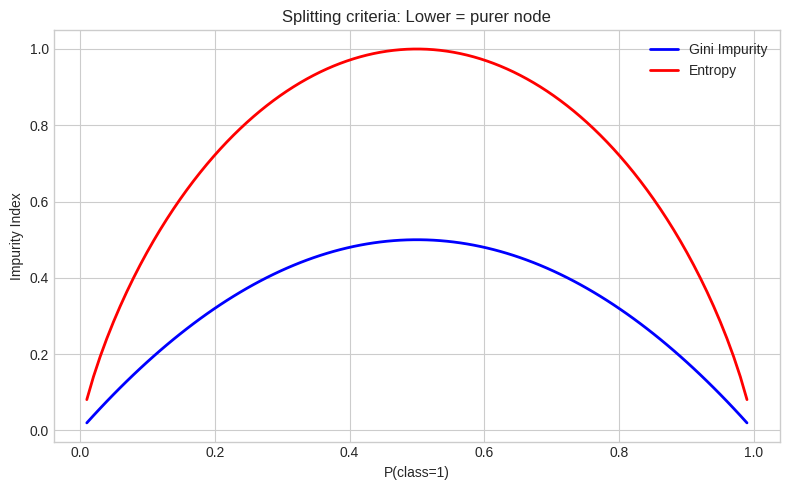

In [2]:
#Setting criteria visualization:
def gini(p):
  return 2 * p * (1 - p)
def entropy(p):
  if p == 0 or p == 1:
    return 0
  return -p * np.log2(p) - (1-p) * np.log2(1-p)

p_range = np.linspace(0.01, 0.99, 100)

plt.figure(figsize=(8, 5))
plt.plot(p_range, [gini(p) for p in p_range], 'b-', label='Gini Impurity', linewidth=2)
plt.plot(p_range, [entropy(p) for p in p_range], 'r-', label='Entropy', linewidth=2)
plt.xlabel("P(class=1)")
plt.ylabel("Impurity Index")
plt.legend()
plt.title('Splitting criteria: Lower = purer node')
plt.tight_layout()
plt.show()

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"

columns = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
           'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
           'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
           'stalk-surface-below-ring', 'stalk-color-above-ring',
           'stalk-color-below-ring', 'veil-type', 'veil-color',
           'ring-number', 'ring-type', 'spore-print-color',
           'population', 'habitat']
df = pd.read_csv(url, names=columns)
print(f"Dataset: {df.shape[0]} mushrooms, {df.shape[1]} features")
df.head()

Dataset: 8124 mushrooms, 23 features


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


class
e    4208
p    3916
Name: count, dtype: int64
e: edible, p: poisonous


<Axes: xlabel='class'>

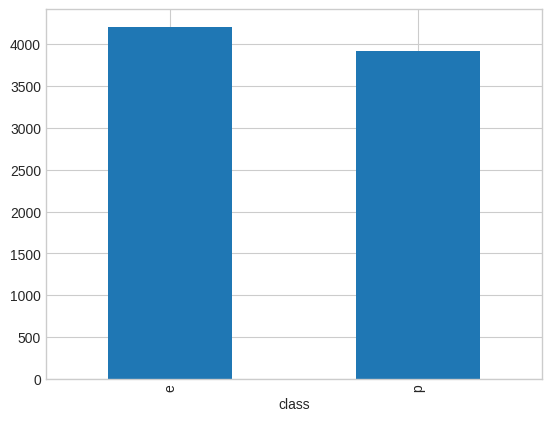

In [4]:
#Target distribution
print(df['class'].value_counts())
print('e: edible, p: poisonous')
df['class'].value_counts().plot(kind='bar')

In [5]:
#Handle missing values
df = df.replace('?' , np.nan)
print(f"Missing Values: {df.isnull().sum().sum()}")
df=df.dropna()
print(f"After dropping: {len(df)} samples")

Missing Values: 2480
After dropping: 5644 samples


In [6]:
#encoding categorical variables
df_encoded = df.copy()
le_dict = {}

for col in df.columns:
  le = LabelEncoder()
  df_encoded[col] = le.fit_transform(df[col])
  le_dict[col] = le

df_encoded.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,2,...,2,5,5,0,0,1,3,1,3,5
1,0,5,2,7,1,0,1,0,0,2,...,2,5,5,0,0,1,3,2,2,1
2,0,0,2,6,1,3,1,0,0,3,...,2,5,5,0,0,1,3,2,2,3
3,1,5,3,6,1,6,1,0,1,3,...,2,5,5,0,0,1,3,1,3,5
4,0,5,2,3,0,5,1,1,0,2,...,2,5,5,0,0,1,0,2,0,1


In [7]:
x = df_encoded.drop('class', axis=1)
y = df_encoded['class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42, stratify=y)
print(f"Train: {len(x_train)} samples")
print(f"Test: {len(x_test)} samples")

Train: 4515 samples
Test: 1129 samples


Training a Decision Tree

In [8]:
#First train with no constraints (will likely overfit)
tree_full = DecisionTreeClassifier(random_state=42)
tree_full.fit(x_train, y_train)

print("Full Tree:")
print(f"Depth: {tree_full.get_depth()}")
print(f"Leaves: {tree_full.get_n_leaves()}")
print(f"Train Accuracy: {tree_full.score(x_train, y_train)}")
print(f"Test Accuracy: {tree_full.score(x_test, y_test)}")

Full Tree:
Depth: 5
Leaves: 10
Train Accuracy: 1.0
Test Accuracy: 1.0


In [9]:
#Training a simpler tree
tree_simple = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_simple.fit(x_train, y_train)

print("Simple Tree:")
print(f"Depth: {tree_simple.get_depth()}")
print(f"Leaves: {tree_simple.get_n_leaves()}")
print(f"Train Accuracy: {tree_simple.score(x_train, y_train)}")
print(f"Test Accuracy:` {tree_simple.score(x_test, y_test)}")

Simple Tree:
Depth: 3
Leaves: 5
Train Accuracy: 0.9561461794019933
Test Accuracy:` 0.9486271036315324


Overfitting and pruning

Best Depth: 5


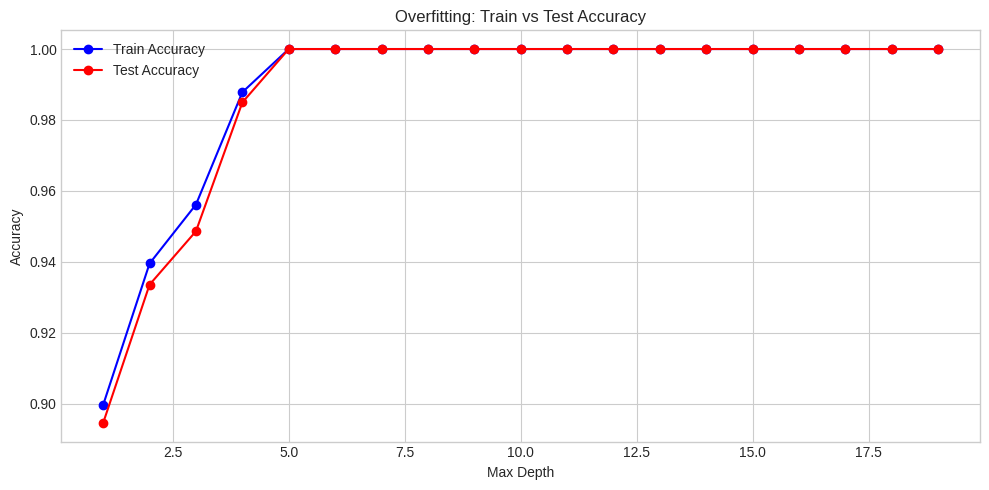

In [10]:
#Effect of max_depth on train vs test accuracy
depths = range(1, 20)
train_scores = []
test_scores = []

for depth in depths:
  tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
  tree.fit(x_train, y_train)
  train_scores.append(tree.score(x_train, y_train))
  test_scores.append(tree.score(x_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(depths, train_scores, 'b-o', label='Train Accuracy')
plt.plot(depths, test_scores, 'r-o', label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title("Overfitting: Train vs Test Accuracy")
plt.tight_layout()
plt.legend()

base_depth = depths[np.argmax(test_scores)]
print(f"Best Depth: {base_depth}")

Best ccp_alpha: 0.000000


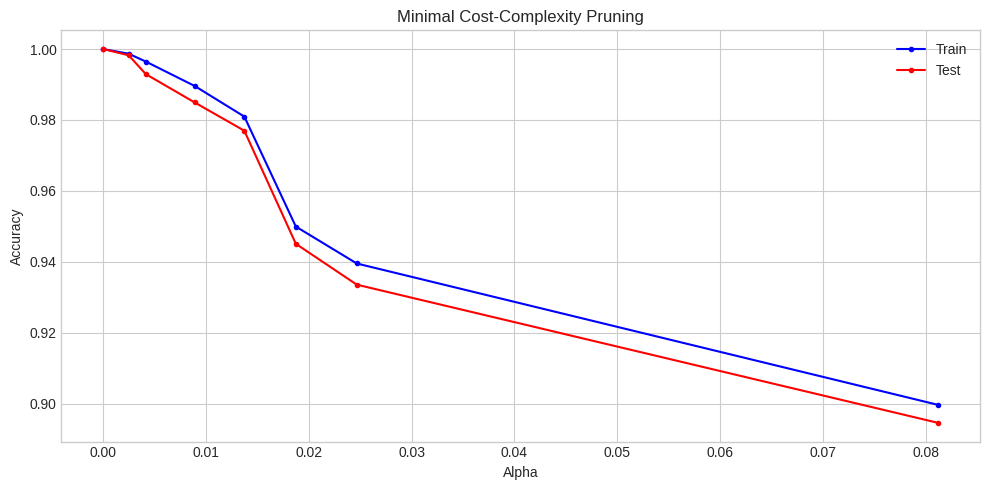

In [15]:
"""
Pruning parameters
- min_samples_split: Minimum number of samples required to split an
- max_depth: Maximum depth of the tree
- min_samples_leaf: Minimum number of samples required to be at a leaf node
- max_leaf_nodes: Maximum number of leaf nodes
- ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning

"""
path = tree_full.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas = path.ccp_alphas[:-1] #Exclude the trivial tree

train_scores_ccp = []
test_scores_ccp = []

for alpha in ccp_alphas:
  tree = DecisionTreeClassifier(ccp_alpha=alpha, random_state=42)
  tree.fit(x_train, y_train)
  train_scores_ccp.append(tree.score(x_train, y_train))
  test_scores_ccp.append(tree.score(x_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(ccp_alphas, train_scores_ccp, 'b-', label='Train', marker='o', markersize=3)
plt.plot(ccp_alphas, test_scores_ccp, 'r-', label='Test', marker='o', markersize=3)

plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title("Minimal Cost-Complexity Pruning")
plt.tight_layout()
plt.legend()

best_alpha = ccp_alphas[np.argmax(test_scores_ccp)]
print(f"Best ccp_alpha: {best_alpha:.6f}")

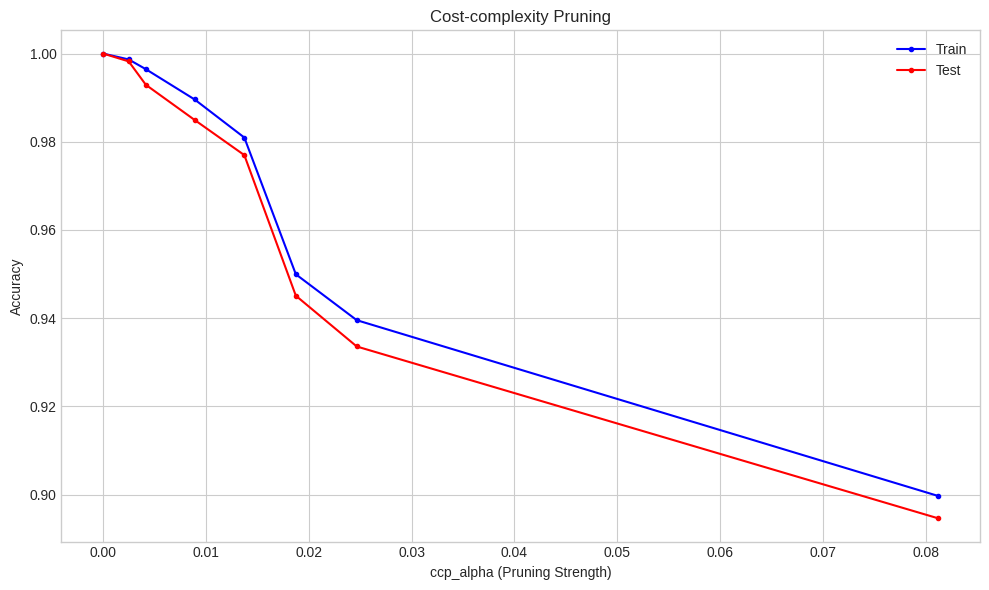

In [17]:
#Cost-complexity pruning (ccp_alpha)
path = tree_full.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]

train_scores_ccp = []
test_scores_ccp = []

for alpha in ccp_alphas:
  tree = DecisionTreeClassifier(ccp_alpha=alpha, random_state=42)
  tree.fit(x_train, y_train)
  train_scores_ccp.append(tree.score(x_train, y_train))
  test_scores_ccp.append(tree.score(x_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores_ccp, 'b-', label='Train', marker='o', markersize=3)
plt.plot(ccp_alphas, test_scores_ccp, 'r-', label='Test', marker='o', markersize=3)
plt.xlabel('ccp_alpha (Pruning Strength)')
plt.ylabel('Accuracy')
plt.title("Cost-complexity Pruning")
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
"""
Hyperparameter Tuning

"""

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print("Test Score:", grid_search.score(x_test, y_test))

Best Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 1.0
Test Score: 1.0


In [24]:
best_tree = grid_search.best_estimator_

print("Best Tree Structure: ")
print(f"Depth: {best_tree.get_depth()}")
print(f"Leaves: {best_tree.get_n_leaves()}")

Best Tree Structure: 
Depth: 5
Leaves: 10


Feature Importance

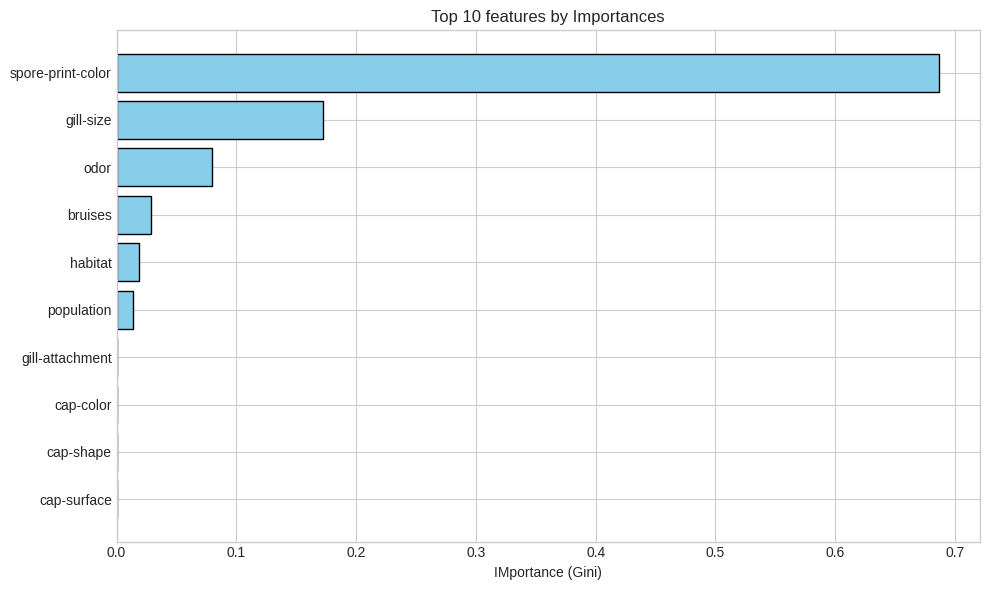

TOp 5 features:
          Feature  Importance
spore-print-color    0.686629
        gill-size    0.172022
             odor    0.079379
          bruises    0.029077
          habitat    0.018843


In [25]:
#Feature importance from best tree
importance_df  = pd.DataFrame({
    'Feature': x.columns,
    'Importance': best_tree.feature_importances_
}).sort_values('Importance', ascending=False)

top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:top_n][::-1],
         importance_df['Importance'][:top_n][::-1],
         color='skyblue', edgecolor='black')
plt.xlabel('IMportance (Gini)')
plt.title(f"Top {top_n} features by Importances")
plt.tight_layout()
plt.show()

print("TOp 5 features:")
print(importance_df.head().to_string(index=False))

In [27]:
print("\nspore-print-color vs Class")
print(pd.crosstab(df['spore-print-color'], df['class'], normalize='index').round(2))


spore-print-color vs Class
class                 e     p
spore-print-color            
h                  0.00  1.00
k                  0.88  0.12
n                  0.88  0.12
r                  0.00  1.00
u                  1.00  0.00
w                  0.65  0.35


Gini vs Entropy

In [28]:
tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
tree_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

tree_gini.fit(x_train, y_train)
tree_entropy.fit(x_train, y_train)

print("Gini Tree:")
print(f"Gini - Leaves {tree_gini.get_n_leaves()}, Test Accuracy: {tree_gini.score(x_test, y_test)}")
print("Entropy Tree:")
print(f"Entropy - Leaves {tree_entropy.get_n_leaves()}, Test Accuracy: {tree_entropy.score(x_test, y_test)}")

Gini Tree:
Gini - Leaves 10, Test Accuracy: 1.0
Entropy Tree:
Entropy - Leaves 10, Test Accuracy: 1.0


Regression Trees

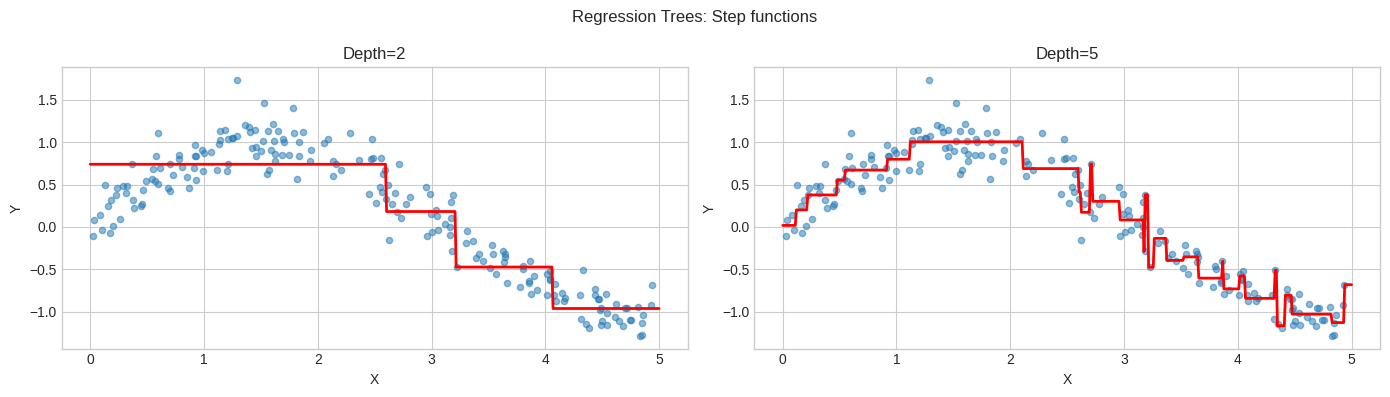

In [32]:
np.random.seed(42)
x_reg = np.sort(5 * np.random.rand(200, 1), axis=0)
y_reg = np.sin(x_reg).ravel() + np.random.normal(0, 0.2, 200)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, depth in zip(axes, [2, 5, 10]):
  tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=42)
  tree_reg.fit(x_reg, y_reg)

  x_plot = np.linspace(0, 5, 500).reshape(-1, 1)
  y_plot = tree_reg.predict(x_plot)

  ax.scatter(x_reg, y_reg, s=20, alpha=0.5)
  ax.plot(x_plot, y_plot, 'r-', linewidth=2)
  ax.set_title(f'Depth={depth}')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')

plt.suptitle('Regression Trees: Step functions')
plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00       698
   poisonous       1.00      1.00      1.00       431

    accuracy                           1.00      1129
   macro avg       1.00      1.00      1.00      1129
weighted avg       1.00      1.00      1.00      1129



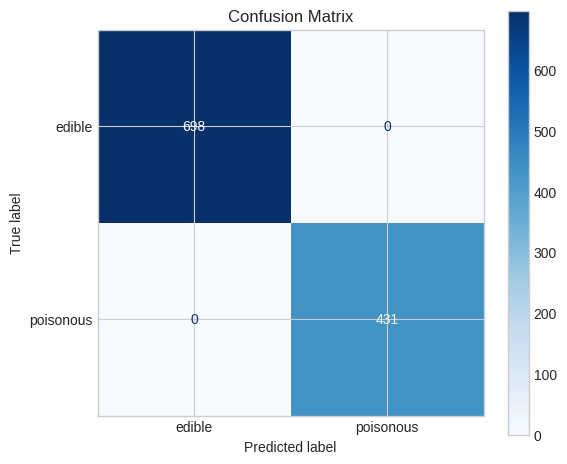

In [34]:
# Final model evaluation
y_pred = best_tree.predict(x_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['edible', 'poisonous']))

# Confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                         display_labels=['edible', 'poisonous'],
                                         cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()


## Summary

### Decision Tree Essentials

| Concept | Description |
|---------|-------------|
| Splitting | Gini (default) or Entropy |
| Overfitting | Deep trees memorize noise |
| Pruning | max_depth, min_samples_*, ccp_alpha |
| Feature Importance | Based on impurity reduction |

### Pros
- Interpretable (rules)
- No scaling needed
- Handles non-linear relationships
- Fast training

### Cons
- Prone to overfitting
- Unstable (small data changes → different tree)
- Biased toward features with more levels

### Solution to Cons?
**Ensemble methods** (Random Forest, Gradient Boosting) — coming soon!